In [50]:
import os
import numpy as np
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2, convolve

from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool


plt.rcParams['figure.figsize'] = (20, 8)

In [51]:
AVAILABLE_CPU = multiprocessing.cpu_count()

In [2]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('X.npy')
        Y = np.load('Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X, X_test, Y, Y_test


if __name__ == '__main__':
    X, X_test, Y, Y_test = get_dataset()

In [3]:
def custom():
    
    Gx = np.array([[-0.25, -0.55, -0.25],[-0.55, 0.9, -0.55], [-0.25, -0.55,-0.25]] )
    return Gx

In [4]:
def customfiltering(img):

    custom_filter = custom()
    smooth_img = conv2(img, custom_filter,mode='same', boundary = 'fill')
    return np.array(smooth_img)

In [5]:
# cleaning
subset = [0,1,2,3,4,5,6,7,8,9,10,53,54,55,56,57,58,59,60,61,62,63]
def cleaning(img, rows):
    for row in rows:
        img[row][0:10] = 1
        img[row][53:64] = 1
    return img

In [6]:
def rgb2gray(rgb):
    '''
    RGB -> gray_scale
    '''
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [43]:
def clean_image(image, threshold = 0.5, new_size_tuple = (64,64)):
    new_img = []
    for el in image.flat: 
        if el > threshold: new_img.append(1)
        else: new_img.append(0)
        
    return np.array(new_img).reshape(new_size_tuple)

In [44]:
img = X[1]
    
new_img = clean_image(img)

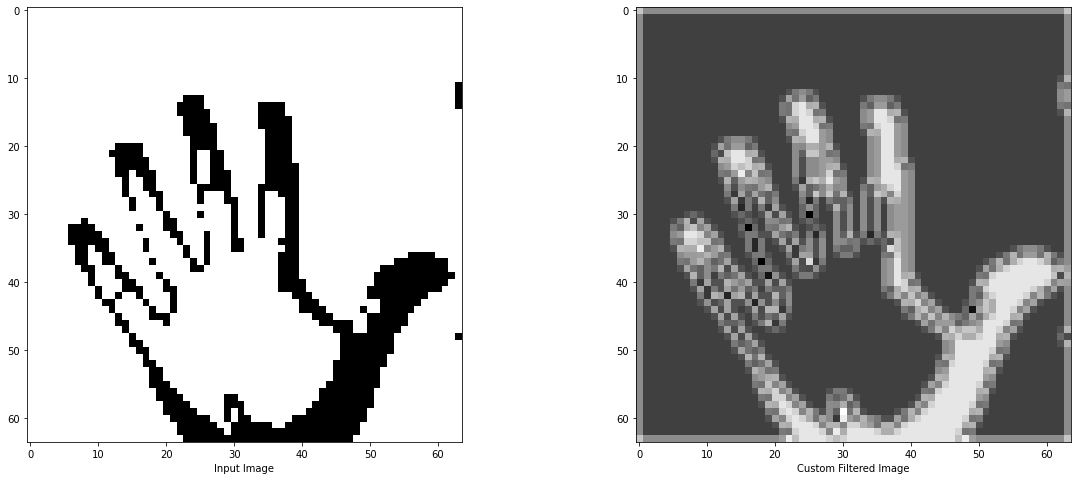

In [45]:
img = cleaning(new_img, subset)
smooth_img = customfiltering(img)
#print(smooth_img.shape)
plt.figure(2)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('Input Image')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('Custom Filtered Image')
plt.sca(ax1)
plt.imshow(img, cmap='gray')
plt.sca(ax2)
plt.imshow(smooth_img, cmap='gray')
plt.show()

In [142]:
# let's split the dataset into relative matrix

y_v_amounts = {}
priorsDictionary = {}
tot_y = len(Y)

# compute priors
for y_i in Y:

    idx = str(np.where(y_i == 1)[0][0])

    if(idx in list(priorsDictionary.keys())):
        y_v_amounts[idx] += 1
        priorsDictionary[idx] += 1/tot_y
    else:
        y_v_amounts[idx] = 1
        priorsDictionary[idx] = 1/tot_y

print(priorsDictionary)

vals = list(priorsDictionary.values())
assert(np.round(np.sum(vals)) == 1), f"Priors don't sum up to 1! Their sum is...: {np.sum(vals)}"

{'5': 0.10309278350515441, '9': 0.09763493026076389, '6': 0.10066707095209196, '0': 0.09945421467556073, '8': 0.09763493026076389, '2': 0.09460278956943582, '3': 0.10430563978168564, '7': 0.10187992722862318, '4': 0.10551849605821687, '1': 0.09520921770770144}


In [143]:
def compute_ground_matrix_couple(index, y_i, X):
    '''
    This takes as input the index of a groundtruth and the groundtruth itself aswell as the dataset.
    First it finds the image in position [y_i], 
    it then computes its cleaned matrix and returns it as a key value pair.
    '''
    
    ground_truth = str(np.where(y_i == 1)[0][0])
    image = clean_image(X[index])
    print(f"image {image}")
    return (ground_truth, image)


def matrix_addition(A, B) :
    return [[A[i][j] + B[i][j]  for j in range(len(A[0]))] for i in range(len(A))]



def compute_posteriors_mt(Y, X, counts):
    '''
    This works similar to a map reduce approach:
    it finds every image for every ground truth and then zips them into a singular one which becomes of probabilities.
    '''
    results = Parallel(n_jobs = AVAILABLE_CPU)(delayed(lambda index, y_i : compute_ground_matrix_couple(index, y_i, X))(index, y_i) for index, y_i in enumerate(Y))

    posteriors = {str(x):np.zeros((64,64)) for x, _ in results}

    for g_truth, matrix in results: posteriors[str(g_truth)] = matrix_addition(matrix, posteriors[str(g_truth)])
    for g_truth, matrix in posteriors.items() :
        posteriors[str(g_truth)] = np.divide(matrix , counts[str(g_truth)])
   
    return posteriors

  
# using map

    
    

In [144]:
posteriorsDict = {}
# initialize posteriors matrixes
for key in priorsDictionary.keys():
    posteriorsDict[key] = np.array(X[0].shape)

# compute posteriors for every image in the dataset
posteriors = compute_posteriors_mt(Y,X, y_v_amounts)



C'è qualcosa che non va con i posteriors lol scusate

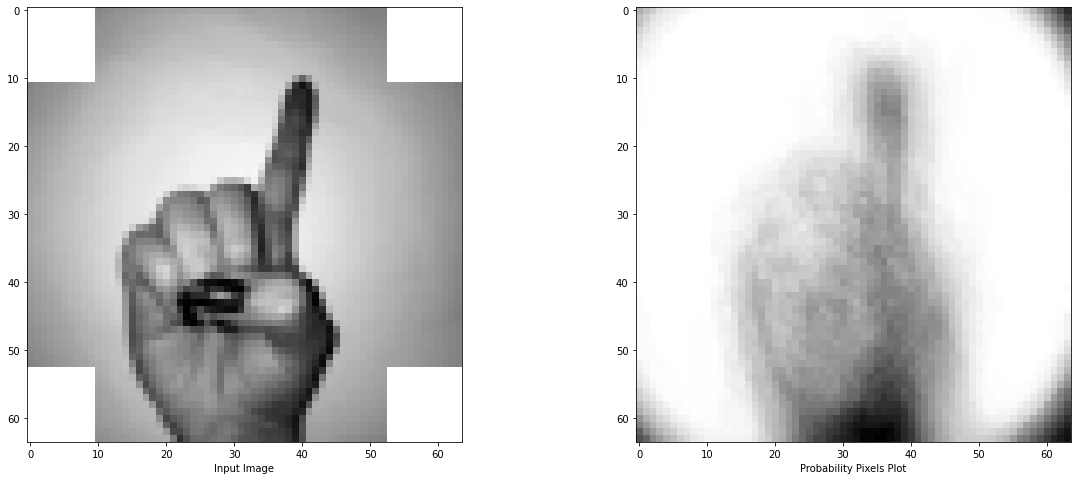

In [152]:
image_0 = cleaning(X[20], subset)
#print(smooth_img.shape)
plt.figure(2)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('Input Image')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('Probability Pixels Plot')
plt.sca(ax1)
plt.imshow(image_0, cmap='gray')
plt.sca(ax2)
plt.imshow(posteriors['4'], cmap='gray')
plt.show()